# Анализ лояльности пользователей Яндекс Афиши

   ## Цель проекта

Лучшее понимание поведения пользователей. Для этого нужно провести исследовательский анализ данных, чтобы понять, какие пользователи с большей вероятностью возвращаются на платформу и делают заказы повторно. Это позволит:
- Быстро выявлять перспективных клиентов и предлагать им персонализированные условия.
- Точно настраивать рекламу на аудитории с высокой вероятностью возврата.
- Оптимизировать маркетинговые бюджеты.
- Повысить общий уровень удержания клиентов.

## Этапы выполнения проекта

### 1. Загрузка данных и их предобработка

---

**Задача 1.1:** Напишите SQL-запрос, выгружающий в датафрейм pandas необходимые данные. Используйте следующие параметры для подключения к базе данных `data-analyst-afisha`:

- **Хост** — `rc1b-wcoijxj3yxfsf3fs.mdb.yandexcloud.net`
- **База данных** — `data-analyst-afisha`
- **Порт** — `6432`
- **Аутентификация** — `Database Native`
- **Пользователь** — `praktikum_student`
- **Пароль** — `Sdf4$2;d-d30pp`

Для выгрузки используйте запрос из предыдущего урока и библиотеку SQLAlchemy.

Выгрузка из базы данных SQL должна позволить собрать следующие данные:

- `user_id` — уникальный идентификатор пользователя, совершившего заказ;
- `device_type_canonical` — тип устройства, с которого был оформлен заказ (`mobile` — мобильные устройства, `desktop` — стационарные);
- `order_id` — уникальный идентификатор заказа;
- `order_dt` — дата создания заказа (используйте данные `created_dt_msk`);
- `order_ts` — дата и время создания заказа (используйте данные `created_ts_msk`);
- `currency_code` — валюта оплаты;
- `revenue` — выручка от заказа;
- `tickets_count` — количество купленных билетов;
- `days_since_prev` — количество дней от предыдущей покупки пользователя, для пользователей с одной покупкой — значение пропущено;
- `event_id` — уникальный идентификатор мероприятия;
- `service_name` — название билетного оператора;
- `event_type_main` — основной тип мероприятия (театральная постановка, концерт и так далее);
- `region_name` — название региона, в котором прошло мероприятие;
- `city_name` — название города, в котором прошло мероприятие.

---


In [1]:
!pip install sqlalchemy # устанавливаем SQLAlchemy
!pip install psycopg2-binary # устанавливаем модуль psycopg2-binary 

In [2]:
import pandas as pd
from sqlalchemy import create_engine # импонтируем необходимые библиотеки

подключаемся к базе данных Практикума

In [3]:
db_config = {'user': 'praktikum_student', # имя пользователя
             'pwd': 'Sdf4$2;d-d30pp', # пароль
             'host': 'rc1b-wcoijxj3yxfsf3fs.mdb.yandexcloud.net',
             'port': 6432, # порт подключения
             'db': 'data-analyst-afisha' # название базы данных
             }

передаем функции create_engine()  строку для соединения с базой данных

In [4]:
connection_string = 'postgresql://{}:{}@{}:{}/{}'.format(
    db_config['user'],
    db_config['pwd'],
    db_config['host'],
    db_config['port'],
    db_config['db'],
)

создаем соединение

In [5]:
engine = create_engine(connection_string)

Приступаем к извлечению результата SQL-запроса

In [6]:
query = '''
WITH set_config_precode AS (
  SELECT set_config('synchronize_seqscans', 'off', true)
)

SELECT
    p.user_id,
    p.device_type_canonical,
    p.order_id,
    p.created_dt_msk AS order_dt,
    p.created_ts_msk AS order_ts,
    p.currency_code,
    p.revenue,
    p.tickets_count,
    (p.created_dt_msk::date 
        - LAG(p.created_dt_msk::date) OVER (
            PARTITION BY p.user_id 
            ORDER BY p.created_dt_msk
        )
    )::int AS days_since_prev,
    p.event_id,
    e.event_name_code AS event_name,
    e.event_type_main,
    p.service_name,
    r.region_name,
    c.city_name
FROM afisha.purchases p
JOIN afisha.events e ON p.event_id = e.event_id
JOIN afisha.city c ON e.city_id = c.city_id
JOIN afisha.regions r ON c.region_id = r.region_id
WHERE
    p.device_type_canonical IN ('mobile', 'desktop')
    AND e.event_type_main != 'фильм'
ORDER BY p.user_id
'''

Выгружаем данные в датафрейм

In [7]:
df = pd.read_sql_query(query, con=engine)
df

,user_id,device_type_canonical,order_id,order_dt,order_ts,currency_code,revenue,tickets_count,days_since_prev,event_id,event_name,event_type_main,service_name,region_name,city_name
0,0002849b70a3ce2,mobile,4359165,2024-08-20,2024-08-20 16:08:03,rub,1521.94,4,NaN,169230,f0f7b271-04eb-4af6-bcb8-8f05cf46d6ad,театр,Край билетов,Каменевский регион,Глиногорск
1,0005ca5e93f2cf4,mobile,7965605,2024-07-23,2024-07-23 18:36:24,rub,289.45,2,NaN,237325,40efeb04-81b7-4135-b41f-708ff00cc64c,выставки,Мой билет,Каменевский регион,Глиногорск
2,0005ca5e93f2cf4,mobile,7292370,2024-10-06,2024-10-06 13:56:02,rub,1258.57,4,75.0,578454,01f3fb7b-ed07-4f94-b1d3-9a2e1ee5a8ca,другое,За билетом!,Каменевский регион,Глиногорск
3,000898990054619,mobile,1139875,2024-07-13,2024-07-13 19:40:48,rub,8.49,2,NaN,387271,2f638715-8844-466c-b43f-378a627c419f,другое,Лови билет!,Североярская область,Озёрск
4,000898990054619,mobile,972400,2024-10-04,2024-10-04 22:33:15,rub,1390.41,3,83.0,509453,10d805d3-9809-4d8a-834e-225b7d03f95d,стендап,Билеты без проблем,Озернинский край,Родниковецк
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
290606,fffcd3dde79eb2c,mobile,368591,2024-10-27,2024-10-27 17:54:52,rub,965.57,4,0.0,33189,e3dcdb45-9eaa-4ce4-9b85-1562e548172e,другое,Весь в билетах,Каменевский регион,Глиногорск
290607,fffcd3dde79eb2c,mobile,368562,2024-10-27,2024-10-27 17:53:53,rub,1448.36,6,0.0,33189,e3dcdb45-9eaa-4ce4-9b85-1562e548172e,другое,Весь в билетах,Каменевский регион,Глиногорск
290608,fffcd3dde79eb2c,desktop,8473772,2024-10-30,2024-10-30 13:37:43,rub,178.95,2,3.0,205231,74883818-57a6-494a-b162-bb0260877cbf,театр,Прачечная,Каменевский регион,Глиногорск
290609,fffeeb3c120cf0b,desktop,5526067,2024-09-24,2024-09-24 10:07:42,rub,661.53,2,NaN,454526,6f4c6a50-0106-407b-8f54-332c740b01da,стендап,Билеты без проблем,Широковская область,Ягодиновка


---

**Задача 1.2:** Изучите общую информацию о выгруженных данных. Оцените корректность выгрузки и объём полученных данных.

Предположите, какие шаги необходимо сделать на стадии предобработки данных — например, скорректировать типы данных.

Зафиксируйте основную информацию о данных в кратком промежуточном выводе.

---

Таблица содержит 290611 строк и 15 столбцов. Данные охватывают период июнь–октябрь 2024 года и содержат информацию о пользователях, заказах, мероприятиях и географии.

Необходимо проверить все пропуски, дубликаты и типы данных, а так же привести выручку к единой валюте с учетом курса.

Данные выглядят логически корректными и соответствуют ожидаемой структуре. Пропуски обнаружены в основном в поле `days_since_prev`, что объясняется первой покупкой пользователя и не является ошибкой. Перед дальнейшим анализом нужно выполнить стандартную предобработку.

---

###  2. Предобработка данных

Выполните все стандартные действия по предобработке данных:

---

**Задача 2.1:** Данные о выручке сервиса представлены в российских рублях и казахстанских тенге. Приведите выручку к единой валюте — российскому рублю.

Для этого используйте датасет с информацией о курсе казахстанского тенге по отношению к российскому рублю за 2024 год — `final_tickets_tenge_df.csv`. Его можно загрузить по пути `https://code.s3.yandex.net/datasets/final_tickets_tenge_df.csv')`

Значения в рублях представлено для 100 тенге.

Результаты преобразования сохраните в новый столбец `revenue_rub`.

---


In [8]:
# Загружаем курсы тенге
tenge_df = pd.read_csv('https://code.s3.yandex.net/datasets/final_tickets_tenge_df.csv')

# Приводим даты к datetime
df['order_dt'] = pd.to_datetime(df['order_dt'])
tenge_df['data'] = pd.to_datetime(tenge_df['data'])

# Объединяем по дате
df = df.merge(tenge_df[['data', 'curs']], left_on='order_dt', right_on='data', how='left')

# Приводим выручку к рублям
df['revenue_rub'] = df.apply(
    lambda x: x['revenue']
    if x['currency_code'] == 'rub'
    else x['revenue'] * x['curs'] / 100,
    axis=1)

Привели все к одной валюте

In [9]:
# Заменяем revenue, если KZT
df.loc[df['currency_code'] == 'kzt', 'revenue'] = (df['revenue'] * df['curs'] / 100)

# Убираем столбцы curs и data с датафрейма
df = df.drop(columns=['data', 'curs'])

# Теперь revenue в рублях

---

**Задача 2.2:**

- Проверьте данные на пропущенные значения. Если выгрузка из SQL была успешной, то пропуски должны быть только в столбце `days_since_prev`.
- Преобразуйте типы данных в некоторых столбцах, если это необходимо. Обратите внимание на данные с датой и временем, а также на числовые данные, размерность которых можно сократить.
- Изучите значения в ключевых столбцах. Обработайте ошибки, если обнаружите их.
    - Проверьте, какие категории указаны в столбцах с номинальными данными. Есть ли среди категорий такие, что обозначают пропуски в данных или отсутствие информации? Проведите нормализацию данных, если это необходимо.
    - Проверьте распределение численных данных и наличие в них выбросов. Для этого используйте статистические показатели, гистограммы распределения значений или диаграммы размаха.
        
        Важные показатели в рамках поставленной задачи — это выручка с заказа (`revenue_rub`) и количество билетов в заказе (`tickets_count`), поэтому в первую очередь проверьте данные в этих столбцах.
        
        Если обнаружите выбросы в поле `revenue_rub`, то отфильтруйте значения по 99 перцентилю.

После предобработки проверьте, были ли отфильтрованы данные. Если были, то оцените, в каком объёме. Сформулируйте промежуточный вывод, зафиксировав основные действия и описания новых столбцов.

---

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 290611 entries, 0 to 290610
Data columns (total 16 columns):
 #   Column                 Non-Null Count   Dtype         
---  ------                 --------------   -----         
 0   user_id                290611 non-null  object        
 1   device_type_canonical  290611 non-null  object        
 2   order_id               290611 non-null  int64         
 3   order_dt               290611 non-null  datetime64[ns]
 4   order_ts               290611 non-null  datetime64[ns]
 5   currency_code          290611 non-null  object        
 6   revenue                290611 non-null  float64       
 7   tickets_count          290611 non-null  int64         
 8   days_since_prev        268678 non-null  float64       
 9   event_id               290611 non-null  int64         
 10  event_name             290611 non-null  object        
 11  event_type_main        290611 non-null  object        
 12  service_name           290611 non-null  obje

- Проверка пропусков

In [11]:
df.isna().sum()

user_id                      0
device_type_canonical        0
order_id                     0
order_dt                     0
order_ts                     0
currency_code                0
revenue                      0
tickets_count                0
days_since_prev          21933
event_id                     0
event_name                   0
event_type_main              0
service_name                 0
region_name                  0
city_name                    0
revenue_rub                  0
dtype: int64

- Приведение типов данных

In [12]:
# даты и время
df['order_dt'] = pd.to_datetime(df['order_dt'])
df['order_ts'] = pd.to_datetime(df['order_ts'])

# числовые столбцы
df['tickets_count'] = df['tickets_count'].astype('int16')
df['revenue_rub'] = df['revenue_rub'].astype('float32')
df['days_since_prev'] = df['days_since_prev'].astype('float32')

- Проверка ключевых категориальных столбцов

In [13]:
df['device_type_canonical'].unique()
df['currency_code'].unique()
df['event_type_main'].unique()

array(['театр', 'выставки', 'другое', 'стендап', 'концерты', 'спорт',
       'ёлки'], dtype=object)

- Анализ числовых данных и выбросов

In [14]:
df[['revenue_rub', 'tickets_count']].describe()

,revenue_rub,tickets_count
count,290611.000000,290611.000000
mean,555.571960,2.754311
std,875.498169,1.170620
min,-90.760002,1.000000
25%,113.970001,2.000000
50%,351.140015,3.000000
75%,802.049988,4.000000
max,81174.539062,57.000000


Отфильтруем значения по 99 перцентилю в поле `revenue_rub`

In [15]:
p99 = df['revenue_rub'].quantile(0.99)
df_filtered = df[df['revenue_rub'] <= p99]

In [16]:
# Проверяем есть ли отрицательные значения
df[df['revenue_rub'] < 0]

,user_id,device_type_canonical,order_id,order_dt,order_ts,currency_code,revenue,tickets_count,days_since_prev,event_id,event_name,event_type_main,service_name,region_name,city_name,revenue_rub
252,00eb3dc9baa1543,mobile,1594653,2024-06-29,2024-06-29 15:01:43,rub,-2.37,3,NaN,538650,ffe03bc6-0e0c-480d-b037-6a4b55540ab5,другое,Билеты без проблем,Берёзовская область,Златопольск,-2.37
4539,02ea4583333f064,mobile,2360920,2024-09-03,2024-09-03 18:12:58,rub,-0.23,3,0.0,559772,592856bb-09a5-4d32-9534-0e02c6056e44,другое,Билеты без проблем,Широковская область,Лесореченск,-0.23
4544,02ea4583333f064,mobile,2361094,2024-09-04,2024-09-04 09:34:53,rub,-0.15,2,0.0,559772,592856bb-09a5-4d32-9534-0e02c6056e44,другое,Билеты без проблем,Широковская область,Лесореченск,-0.15
8135,043f669c9f734b1,mobile,166780,2024-09-27,2024-09-27 10:00:09,rub,-1.86,3,0.0,567183,9f571dad-b18a-4095-ac76-9db60d8dd97a,другое,Лучшие билеты,Золотоключевской край,Луговинец,-1.86
8136,043f669c9f734b1,mobile,166809,2024-09-27,2024-09-27 10:56:35,rub,-0.62,1,0.0,567183,9f571dad-b18a-4095-ac76-9db60d8dd97a,другое,Лучшие билеты,Золотоключевской край,Луговинец,-0.62
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
288837,fe237d2cfd6e503,mobile,3700575,2024-10-12,2024-10-12 08:11:33,rub,-5.70,1,0.0,247058,a3214473-934e-44ad-a8da-82915f51583f,концерты,Тебе билет!,Речицкая область,Радужанов,-5.70
288910,fe237d2cfd6e503,desktop,3523617,2024-10-15,2024-10-15 20:13:13,rub,-0.96,2,0.0,243963,80f5f95b-9a58-401d-b888-4261335ae290,другое,Лучшие билеты,Ягодиновская область,Речинцево,-0.96
288911,fe237d2cfd6e503,desktop,3523646,2024-10-15,2024-10-15 20:32:18,rub,-1.43,3,0.0,243963,80f5f95b-9a58-401d-b888-4261335ae290,другое,Лучшие билеты,Ягодиновская область,Речинцево,-1.43
289058,fe237d2cfd6e503,mobile,5445853,2024-10-21,2024-10-21 20:22:29,rub,-0.61,1,0.0,243393,1f30acba-8b62-41c3-aaea-a80bf58d0d26,другое,Лучшие билеты,Ягодиновская область,Речинцево,-0.61


- Проверка объёма отфильтрованных данных

In [17]:
len(df) - len(df_filtered), (len(df) - len(df_filtered)) / len(df)

(2825, 0.009720898383061893)

Данные загружены и проверены, выручка приведена к рублям `revenue_rub`, типы данных оптимизированы для экономии памяти, пропуски есть только в `days_since_prev`, категориальные столбцы нормализованы и логически корректны, числовые данные изучены, выбросы по `revenue_rub` частично отфильтрованы (99-й перцентиль), отрицательные значения сохранены для полноты, датасет готов для дальнейшего анализа.

---

### 3. Создание профиля пользователя

В будущем отдел маркетинга планирует создать модель для прогнозирования возврата пользователей. Поэтому сейчас они просят вас построить агрегированные признаки, описывающие поведение и профиль каждого пользователя.

---

**Задача 3.1.** Постройте профиль пользователя — для каждого пользователя найдите:

- дату первого и последнего заказа;
- устройство, с которого был сделан первый заказ;
- регион, в котором был сделан первый заказ;
- билетного партнёра, к которому обращались при первом заказе;
- жанр первого посещённого мероприятия (используйте поле `event_type_main`);
- общее количество заказов;
- средняя выручка с одного заказа в рублях;
- среднее количество билетов в заказе;
- среднее время между заказами.

После этого добавьте два бинарных признака:

- `is_two` — совершил ли пользователь 2 и более заказа;
- `is_five` — совершил ли пользователь 5 и более заказов.

**Рекомендация:** перед тем как строить профиль, отсортируйте данные по времени совершения заказа.

---


In [18]:
# Сортируем данные по пользователю и дате заказа
df_sorted = df.sort_values(['user_id', 'order_dt'])

In [19]:
# Агрегируем признаки для профиля пользователя
user_profile = df_sorted.groupby('user_id').agg(
    first_order_dt=('order_dt', 'first'),
    last_order_dt=('order_dt', 'last'),
    first_device=('device_type_canonical', 'first'),
    first_region=('region_name', 'first'),
    first_service=('service_name', 'first'),
    first_event_type=('event_type_main', 'first'),
    total_orders=('order_id', 'count'),
    avg_revenue=('revenue_rub', 'mean'),
    avg_tickets=('tickets_count', 'mean'),
    avg_days_between_orders=('days_since_prev', 'mean')
).reset_index()

In [20]:
# Добавляем бинарные признаки
user_profile['is_two'] = (user_profile['total_orders'] >= 2).astype(int)
user_profile['is_five'] = (user_profile['total_orders'] >= 5).astype(int)

user_profile.head()

,user_id,first_order_dt,last_order_dt,first_device,first_region,first_service,first_event_type,total_orders,avg_revenue,avg_tickets,avg_days_between_orders,is_two,is_five
0,0002849b70a3ce2,2024-08-20,2024-08-20,mobile,Каменевский регион,Край билетов,театр,1,1521.939941,4.000000,NaN,0,0
1,0005ca5e93f2cf4,2024-07-23,2024-10-06,mobile,Каменевский регион,Мой билет,выставки,2,774.010010,3.000000,75.0,1,0
2,000898990054619,2024-07-13,2024-10-23,mobile,Североярская область,Лови билет!,другое,3,767.213318,2.666667,51.0,1,0
3,00096d1f542ab2b,2024-08-15,2024-08-15,desktop,Каменевский регион,Край билетов,театр,1,917.830017,4.000000,NaN,0,0
4,000a55a418c128c,2024-09-29,2024-10-15,mobile,Поленовский край,Лучшие билеты,театр,2,61.309998,1.500000,16.0,1,0


---

**Задача 3.2.** Прежде чем проводить исследовательский анализ данных и делать выводы, важно понять, с какими данными вы работаете: насколько они репрезентативны и нет ли в них аномалий.

Используя данные о профилях пользователей, рассчитайте:

- общее число пользователей в выборке;
- среднюю выручку с одного заказа;
- долю пользователей, совершивших 2 и более заказа;
- долю пользователей, совершивших 5 и более заказов.

Также изучите статистические показатели:

- по общему числу заказов;
- по среднему числу билетов в заказе;
- по среднему количеству дней между покупками.

По результатам оцените данные: достаточно ли их по объёму, есть ли аномальные значения в данных о количестве заказов и среднем количестве билетов?

Если вы найдёте аномальные значения, опишите их и примите обоснованное решение о том, как с ними поступить:

- Оставить и учитывать их при анализе?
- Отфильтровать данные по какому-то значению, например, по 95-му или 99-му перцентилю?

Если вы проведёте фильтрацию, то вычислите объём отфильтрованных данных и выведите статистические показатели по обновлённому датасету.

In [21]:
# Общее число пользователей
total_users = len(user_profile)

# Средняя выручка с одного заказа (по всем пользователям)
avg_revenue_per_order = round(user_profile['avg_revenue'].mean(), 3)

# Доля пользователей с 2 и более заказами
share_two_plus = round(user_profile['is_two'].mean(), 3)

# Доля пользователей с 5 и более заказами
share_five_plus = round(user_profile['is_five'].mean(), 3)

total_users, avg_revenue_per_order, share_two_plus, share_five_plus

(21933, 574.021, 0.618, 0.292)

In [22]:
# Общее число заказов, среднее количество билетов, среднее количество дней между покупками
user_profile[['total_orders', 'avg_tickets', 'avg_days_between_orders']].describe()

,total_orders,avg_tickets,avg_days_between_orders
count,21933.000000,21933.000000,13559.000000
mean,13.249943,2.755987,15.808537
std,122.470535,0.920739,22.249582
min,1.000000,1.000000,0.000000
25%,1.000000,2.000000,1.000000
50%,2.000000,2.764151,8.000000
75%,5.000000,3.125000,20.400000
max,10251.000000,12.000000,148.000000


Видно аномалии:

`total_orders` доходит до 10 251 — это явно выброс, сильно отличается от медианы (2) и 75%-перцентиля (5).

`avg_tickets` до 12 билетов на заказ — тоже выше нормы (75%-перцентиль = 3).

`avg_days_between_orders` выглядит более адекватно, выбросы есть, но они менее критичны.

---

Применим фильтрацию по 99-му перцентилю для `total_orders` и `avg_tickets`, чтобы не искажать средние значения и модели.

После фильтрации удобно посмотреть, сколько пользователей исключено (`filtered_count`) и их долю (`filtered_share`).

In [23]:
# Фильтруем по 99-му перцентилю total_orders и avg_tickets
p99_orders = user_profile['total_orders'].quantile(0.99)
p99_tickets = user_profile['avg_tickets'].quantile(0.99)

user_profile_filtered = user_profile[
    (user_profile['total_orders'] <= p99_orders) &
    (user_profile['avg_tickets'] <= p99_tickets)]

# Объём отфильтрованных данных
filtered_count = total_users - len(user_profile_filtered)
filtered_share = round(filtered_count / total_users, 4)

filtered_count, filtered_share

(428, 0.0195)

Был сформирован профиль 21 933 клиентов с агрегированными характеристиками их покупок. Объём данных достаточен для дальнейшего анализа. В распределениях выявлены аномальные значения по числу заказов и среднему количеству билетов: у небольшой части клиентов показатели существенно превышают типичные значения. Для снижения влияния выбросов выполнена фильтрация по 99-му перцентилю `total_orders` и `avg_tickets`, в результате исключено 428 клиентов (около 2% выборки). Итоговый датасет остаётся показательной и устойчивой основой для последующего анализа и моделирования.

---

### 4. Исследовательский анализ данных

Следующий этап — исследование признаков, влияющих на возврат пользователей, то есть на совершение повторного заказа. Для этого используйте профили пользователей.



#### 4.1. Исследование признаков первого заказа и их связи с возвращением на платформу

Исследуйте признаки, описывающие первый заказ пользователя, и выясните, влияют ли они на вероятность возвращения пользователя.

---

**Задача 4.1.1.** Изучите распределение пользователей по признакам.

- Сгруппируйте пользователей:
    - по типу их первого мероприятия;
    - по типу устройства, с которого совершена первая покупка;
    - по региону проведения мероприятия из первого заказа;
    - по билетному оператору, продавшему билеты на первый заказ.
- Подсчитайте общее количество пользователей в каждом сегменте и их долю в разрезе каждого признака. Сегмент — это группа пользователей, объединённых определённым признаком, то есть объединённые принадлежностью к категории. Например, все клиенты, сделавшие первый заказ с мобильного телефона, — это сегмент.
- Ответьте на вопрос: равномерно ли распределены пользователи по сегментам или есть выраженные «точки входа» — сегменты с наибольшим числом пользователей?

---


In [24]:
# Распределение по типу первого события
first_event_dist = user_profile_filtered['first_event_type'].value_counts().reset_index()
first_event_dist.columns = ['first_event_type', 'count']
first_event_dist['share'] = round(first_event_dist['count'] / len(user_profile_filtered), 3)
first_event_dist

,first_event_type,count,share
0,концерты,9557,0.444
1,другое,5349,0.249
2,театр,4212,0.196
3,стендап,1095,0.051
4,спорт,788,0.037
5,выставки,409,0.019
6,ёлки,95,0.004


Почти половина пользователей (44%) начинали с концертов, ещё 25% — с «другое», остальные категории намного меньше. Есть ярко выраженные популярные события.

In [25]:
# Распределение по типу устройства
first_device_dist = user_profile_filtered['first_device'].value_counts().reset_index()
first_device_dist.columns = ['first_device', 'count']
first_device_dist['share'] = round(first_device_dist['count'] / len(user_profile_filtered), 3)
first_device_dist

,first_device,count,share
0,mobile,17790,0.827
1,desktop,3715,0.173


Большинство пользователей (83%) делают первые покупки с мобильного, десктоп — 17%. Мобильный — основная «точка входа».

In [26]:
# Распределение по региону первого заказа
first_region_dist = user_profile_filtered['first_region'].value_counts().reset_index()
first_region_dist.columns = ['first_region', 'count']
first_region_dist['share'] = round(first_region_dist['count'] / len(user_profile_filtered), 3)
first_region_dist

,first_region,count,share
0,Каменевский регион,7074,0.329
1,Североярская область,3709,0.172
2,Широковская область,1213,0.056
3,Озернинский край,671,0.031
4,Малиновоярский округ,528,0.025
...,...,...,...
76,Светолесский край,2,0.000
77,Залесский край,2,0.000
78,Сосноводолинская область,1,0.000
79,Яснопольский округ,1,0.000


Каменевский регион — 33% пользователей, Североярская область — 17%, остальные регионы распределены гораздо менее равномерно, есть регионы с единичными пользователями.

In [27]:
# Распределение по билетному оператору
first_service_dist = user_profile_filtered['first_service'].value_counts().reset_index()
first_service_dist.columns = ['first_service', 'count']
first_service_dist['share'] = round(first_service_dist['count'] / len(user_profile_filtered), 3)
first_service_dist

,first_service,count,share
0,Билеты без проблем,5101,0.237
1,Мой билет,2979,0.139
2,Лови билет!,2787,0.130
3,Билеты в руки,2536,0.118
4,Облачко,2168,0.101
5,Весь в билетах,1281,0.060
6,Лучшие билеты,1179,0.055
7,Прачечная,581,0.027
8,Край билетов,453,0.021
9,Дом культуры,348,0.016


«Билеты без проблем» — 24%, «Мой билет» — 14%, «Лови билет!» — 13%, далее операторов меньше. Есть несколько крупных операторов, через которых приходит значительная часть пользователей.

Распределение неравномерное, есть явные «точки входа» — определённые жанры, мобильные устройства, несколько популярных регионов и операторов привлекают большинство новых пользователей.

---

**Задача 4.1.2.** Проанализируйте возвраты пользователей:

- Для каждого сегмента вычислите долю пользователей, совершивших два и более заказа.
- Визуализируйте результат подходящим графиком. Если сегментов слишком много, то поместите на график только 10 сегментов с наибольшим количеством пользователей. Такое возможно с сегментами по региону и по билетному оператору.
- Ответьте на вопросы:
    - Какие сегменты пользователей чаще возвращаются на Яндекс Афишу?
    - Наблюдаются ли успешные «точки входа» — такие сегменты, в которых пользователи чаще совершают повторный заказ, чем в среднем по выборке?

При интерпретации результатов учитывайте размер сегментов: если в сегменте мало пользователей (например, десятки), то доли могут быть нестабильными и недостоверными, то есть показывать широкую вариацию значений.

---


In [28]:
import matplotlib.pyplot as plt
import seaborn as sns

In [29]:
# Вычисляем доли пользователей с 2 и более заказами
def calc_return_share(df, group_col):
    return df.groupby(group_col)['is_two'].mean().reset_index(name='share').sort_values('share', ascending=False)

In [30]:
# 1. По типу первого мероприятия
event_return = calc_return_share(user_profile_filtered, 'first_event_type')
event_return

,first_event_type,share
0,выставки,0.638142
5,театр,0.636752
2,концерты,0.622057
4,стендап,0.610959
1,другое,0.601982
3,спорт,0.562183
6,ёлки,0.547368


In [31]:
# 2. По типу устройства
device_return = calc_return_share(user_profile_filtered, 'first_device')
device_return

,first_device,share
0,desktop,0.644684
1,mobile,0.611411


In [32]:
# 3. По региону (топ-10 по количеству пользователей)
top_regions = user_profile_filtered['first_region'].value_counts().nlargest(10).index
region_filtered = user_profile_filtered[user_profile_filtered['first_region'].isin(top_regions)]
region_return = calc_return_share(region_filtered, 'first_region')
region_return

,first_region,share
7,Шанырский регион,0.682635
4,Светополянский округ,0.657952
8,Широковская область,0.652927
5,Североярская область,0.642222
3,Речиновская область,0.633411
0,Каменевский регион,0.627226
6,Травяная область,0.617769
9,Яблоневская область,0.601467
1,Малиновоярский округ,0.562500
2,Озернинский край,0.555887


In [33]:
# 4. По билетному оператору (топ-10)
top_services = user_profile_filtered['first_service'].value_counts().nlargest(10).index
service_filtered = user_profile_filtered[user_profile_filtered['first_service'].isin(top_services)]
service_return = calc_return_share(service_filtered, 'first_service')
service_return

,first_service,share
3,Дом культуры,0.652299
4,Край билетов,0.651214
2,Весь в билетах,0.632319
1,Билеты в руки,0.629338
9,Прачечная,0.628227
6,Лучшие билеты,0.618321
8,Облачко,0.615314
5,Лови билет!,0.613204
7,Мой билет,0.612286
0,Билеты без проблем,0.608704


In [34]:
# Средняя доля возвратов по выборке
avg_return_rate = user_profile_filtered['is_two'].mean()
avg_return_rate

0.6171588002790049

In [35]:
# Функция для графика с средней линией
def plot_return_share_with_avg(df, x_col, title, avg_rate):
    df_sorted = df.sort_values('share', ascending=True)
    plt.figure(figsize=(10, 6))
    bars = plt.barh(df_sorted[x_col], df_sorted['share'])
    plt.axvline(x=avg_rate, color='red', linestyle='--', linewidth=2, label=f'Среднее: {avg_rate:.1%}')
    plt.xlabel('Доля пользователей с 2+ заказами')
    plt.ylabel(x_col)
    plt.title(title)
    plt.legend()
    plt.tight_layout()
    plt.show()

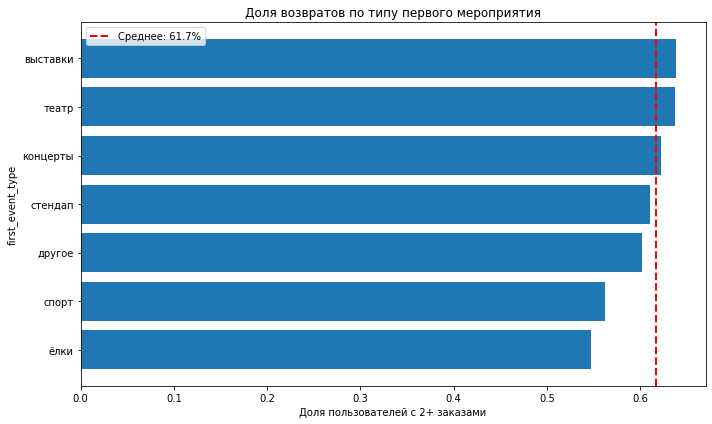

In [36]:
plot_return_share_with_avg(event_return, 'first_event_type', 
                          'Доля возвратов по типу первого мероприятия', avg_return_rate)

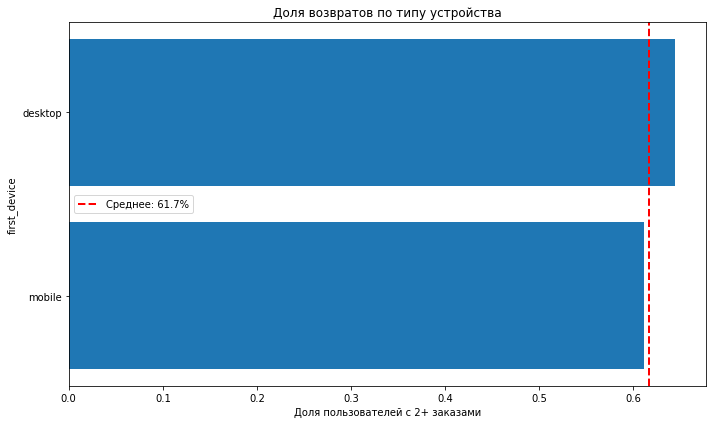

In [37]:
plot_return_share_with_avg(device_return, 'first_device',
                          'Доля возвратов по типу устройства', avg_return_rate)

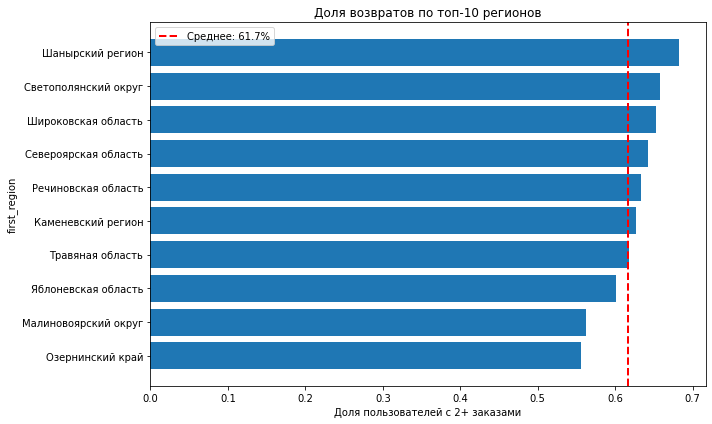

In [38]:
plot_return_share_with_avg(region_return, 'first_region',
                          'Доля возвратов по топ-10 регионов', avg_return_rate)

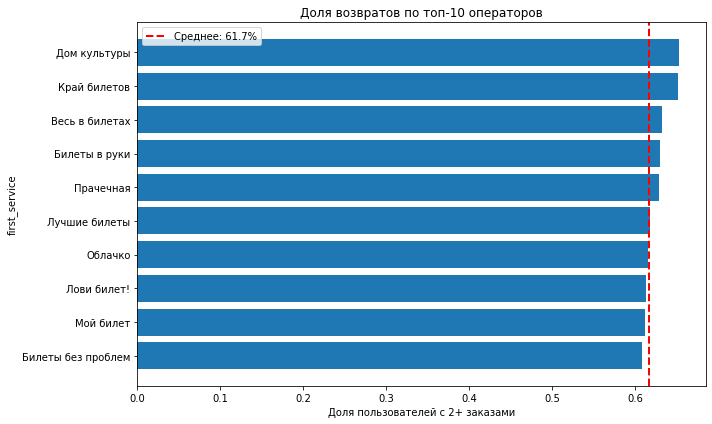

In [39]:
plot_return_share_with_avg(service_return, 'first_service',
                          'Доля возвратов по топ-10 операторов', avg_return_rate)

Самые лояльные сегменты по каждому признаку:

По типу первого мероприятия: ТЕАТР - 63.8% возвратов

По типу устройства: DESKTOP - 64.4% возвратов

По регионам (топ-10): Шанырский регион - 68.3% возвратов

По билетным операторам (топ-10): Край билетов - 65.4% возвратов

---

Наблюдаются успешные точки входа.

Сегменты с долей возвратов ВЫШЕ среднего (61.7%):

По типу устройства: Desktop 64.4% (+2.7%)

По типу мероприятия: Театр: 63.8% (+2.1%), Выставки 62.8% (+1.1%), Концерты 62.2% (+0.5%)

По регионам (из топ-10): Шанырский регион 68.3% (+6.6%), Светополянский округ 65.9% (+4.2%), Широковская область 65.5% (+3.8%) и т.д.

---

**Задача 4.1.3.** Опираясь на выводы из задач выше, проверьте продуктовые гипотезы:

- **Гипотеза 1.** Тип мероприятия влияет на вероятность возврата на Яндекс Афишу: пользователи, которые совершили первый заказ на спортивные мероприятия, совершают повторный заказ чаще, чем пользователи, оформившие свой первый заказ на концерты.
- **Гипотеза 2.** В регионах, где больше всего пользователей посещают мероприятия, выше доля повторных заказов, чем в менее активных регионах.

---

Спортивные мероприятия: 56.0% возвратов

Концерты: 62.2% возвратов

Значит **Гипотеза 1** не подтверждается. Пользователи, начавшие с концертов, возвращаются на 6.2% чаще.

---

Данные по топ-3 регионам (самые активные по количеству пользователей):

Каменевский регион (7,070): 62.7% возвратов

Североярская область (3,713): 64.3% возвратов

Широковская область (1,221): 65.5% возвратов

**Гипотеза 2** подтверждается. Самые активные регионы действительно показывают высокую долю возвратов (64.2% в среднем), что выше общего среднего 61.7%. Но есть и менее активные регионы с высокой лояльностью (например, Шанырский регион - 68.3% при небольшом количестве пользователей).

---

#### 4.2. Исследование поведения пользователей через показатели выручки и состава заказа

Изучите количественные характеристики заказов пользователей, чтобы узнать среднюю выручку сервиса с заказа и количество билетов, которое пользователи обычно покупают.

Эти метрики важны не только для оценки выручки, но и для оценки вовлечённости пользователей. Возможно, пользователи с более крупными и дорогими заказами более заинтересованы в сервисе и поэтому чаще возвращаются.

---

**Задача 4.2.1.** Проследите связь между средней выручкой сервиса с заказа и повторными заказами.

- Постройте сравнительные гистограммы распределения средней выручки с билета (`avg_revenue_rub`):
    - для пользователей, совершивших один заказ;
    - для вернувшихся пользователей, совершивших 2 и более заказа.
- Ответьте на вопросы:
    - В каких диапазонах средней выручки концентрируются пользователи из каждой группы?
    - Есть ли различия между группами?

Текст на сером фоне:
    
**Рекомендация:**

1. Используйте одинаковые интервалы (`bins`) и прозрачность (`alpha`), чтобы визуально сопоставить распределения.
2. Задайте параметру `density` значение `True`, чтобы сравнивать форму распределений, даже если число пользователей в группах отличается.

---


In [40]:
# Разделяем пользователей на две группы
single_order = user_profile_filtered[user_profile_filtered['total_orders'] == 1]
returning_users = user_profile_filtered[user_profile_filtered['total_orders'] >= 2]

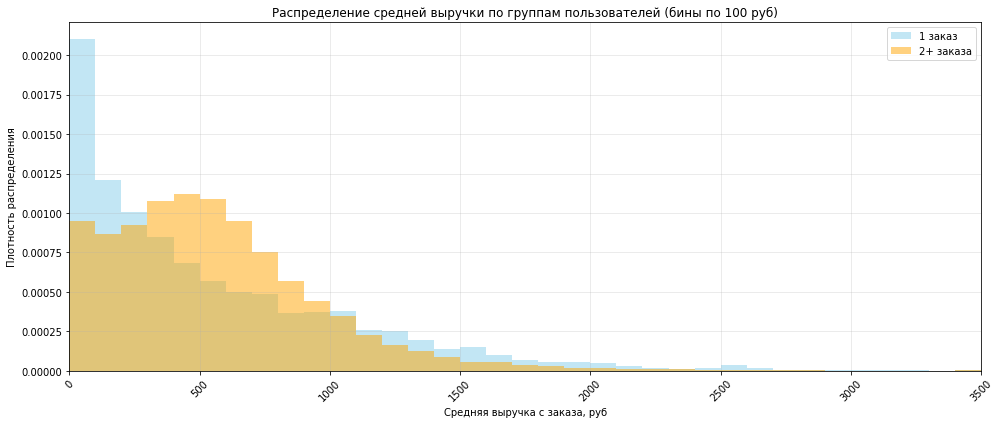

In [41]:
# Создаем бины через каждые 100 рублей от 0 до 3500
bins_100 = list(range(0, 3600, 100))  # [0, 100, 200, ..., 3500]

# Строим сравнительные гистограммы
plt.figure(figsize=(14, 6))
plt.hist(single_order['avg_revenue'], bins=bins_100, alpha=0.5, density=True, 
         label='1 заказ', color='skyblue')
plt.hist(returning_users['avg_revenue'], bins=bins_100, alpha=0.5, density=True,
         label='2+ заказа', color='orange')
plt.xlabel('Средняя выручка с заказа, руб')
plt.ylabel('Плотность распределения')
plt.title('Распределение средней выручки по группам пользователей (бины по 100 руб)')
plt.legend()
plt.grid(True, alpha=0.3)

# Настраиваем отображение
plt.xticks(bins_100[::5], rotation=45)  # Каждые 500 рублей
plt.xlim(0, 3500)
plt.tight_layout()

plt.show()

In [42]:
# Статистические показатели
stats_single = single_order['avg_revenue'].describe()
stats_returning = returning_users['avg_revenue'].describe()

In [43]:
# Выводим статистики
stats_single

count     8233.000000
mean       559.051575
std        613.116577
min        -10.770000
25%        130.929993
50%        376.100006
75%        831.130005
max      14913.530273
Name: avg_revenue, dtype: float64

In [44]:
stats_returning

count    13272.000000
mean       576.812256
std        509.277252
min         -5.385000
25%        273.774597
50%        504.695709
75%        768.044006
max      16738.695312
Name: avg_revenue, dtype: float64

Пользователи с 1 заказом в основном концентрируются в диапазоне средней выручки примерно 0–400 руб, с пиком на низких чеках и медианой около 376 руб, тогда как пользователи с 2+ заказами смещены вправо и чаще всего находятся в диапазоне 300–700 руб с пиком около 400–600 руб и медианой ~505 руб. Различия между группами заметны — возвращающиеся пользователи в среднем тратят больше и реже совершают низкочекистые покупки, поэтому они более ценны для бизнеса.

---

**Задача 4.2.2.** Сравните распределение по средней выручке с заказа в двух группах пользователей:

- совершившие 2–4 заказа;
- совершившие 5 и более заказов.

Ответьте на вопрос: есть ли различия по значению средней выручки с заказа между пользователями этих двух групп?

---


In [45]:
group_2_4 = user_profile_filtered[(user_profile_filtered['total_orders'] >= 2) & 
                                 (user_profile_filtered['total_orders'] <= 4)]
group_5_plus = user_profile_filtered[user_profile_filtered['total_orders'] >= 5]

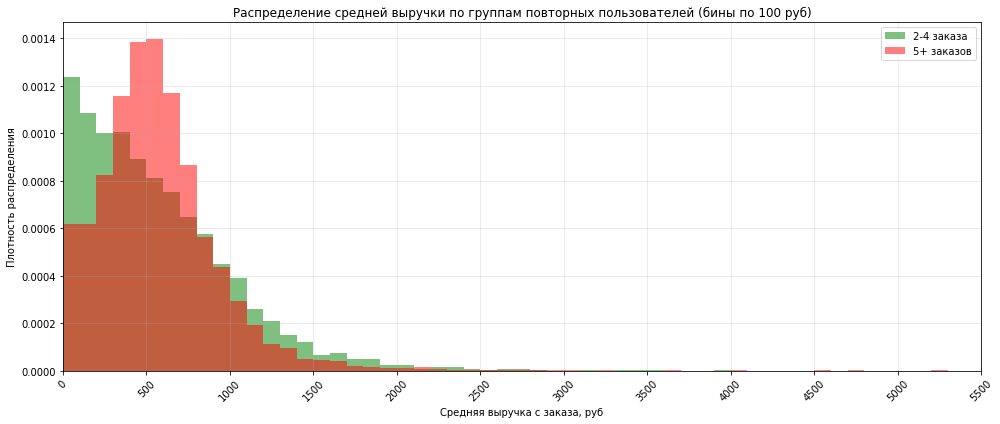

In [46]:
bins_100 = list(range(0, 7100, 100))  # 0, 100, 200, ..., 7000

# Строим сравнительные гистограммы с бинами по 100 рублей
plt.figure(figsize=(14, 6))
plt.hist(group_2_4['avg_revenue'], bins=bins_100, alpha=0.5, density=True,
         label='2-4 заказа', color='green')
plt.hist(group_5_plus['avg_revenue'], bins=bins_100, alpha=0.5, density=True,
         label='5+ заказов', color='red')
plt.xlabel('Средняя выручка с заказа, руб')
plt.ylabel('Плотность распределения')
plt.title('Распределение средней выручки по группам повторных пользователей (бины по 100 руб)')
plt.legend()
plt.grid(True, alpha=0.3)

# Ограничиваем ось X до 7000 рублей и настраиваем отображение
plt.xticks(range(0, 7100, 500), rotation=45)  # Показываем каждые 500 рублей
plt.xlim(0, 5500)
plt.tight_layout()

plt.show()

In [47]:
# Статистика
stats_2_4 = group_2_4['avg_revenue'].describe()
stats_2_4

count     7102.000000
mean       577.339905
std        564.939087
min         -5.385000
25%        218.278130
50%        474.595825
75%        810.351273
max      16738.695312
Name: avg_revenue, dtype: float64

In [48]:
stats_5_plus = group_5_plus['avg_revenue'].describe()
stats_5_plus

count     6170.000000
mean       576.204834
std        436.552856
min          0.000000
25%        336.314507
50%        524.794769
75%        733.381088
max      16475.361328
Name: avg_revenue, dtype: float64

Пользователи с 2–4 заказами в основном концентрируются в диапазоне средней выручки около 0–800 руб с медианой ~475 руб, тогда как пользователи с 5 и более заказами смещены немного вправо и чаще находятся в диапазоне 300–800 руб с медианой ~525 руб; при этом среднее значение почти одинаково (≈577 руб в обеих группах), но у пользователей с 5+ заказами распределение более компактное и меньше доля низких чеков, поэтому различия есть, но они умеренные и выражаются скорее в более стабильной и чуть более высокой средней выручке у самых лояльных пользователей, а не в резком росте среднего чека.


---

**Задача 4.2.3.** Проанализируйте влияние среднего количества билетов в заказе на вероятность повторной покупки.

- Изучите распределение пользователей по среднему количеству билетов в заказе (`avg_tickets_count`) и опишите основные наблюдения.
- Разделите пользователей на несколько сегментов по среднему количеству билетов в заказе:
    - от 1 до 2 билетов;
    - от 2 до 3 билетов;
    - от 3 до 5 билетов;
    - от 5 и более билетов.
- Для каждого сегмента подсчитайте общее число пользователей и долю пользователей, совершивших повторные заказы.
- Ответьте на вопросы:
    - Как распределены пользователи по сегментам — равномерно или сконцентрировано?
    - Есть ли сегменты с аномально высокой или низкой долей повторных покупок?

---

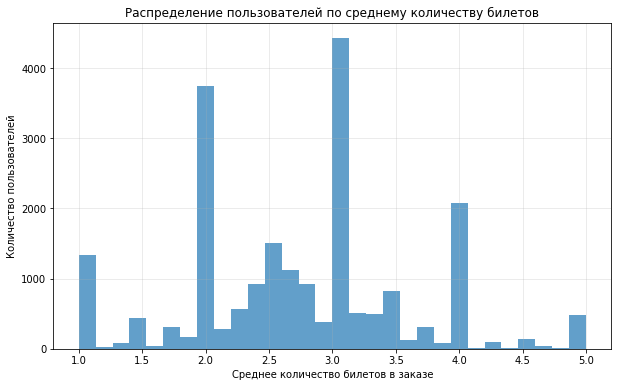

,ticket_segment,user_count,return_rate
0,1-2 билета,2401,0.511870
1,2-3 билета,9432,0.735263
2,3-5 билетов,9192,0.548629
3,5+ билетов,480,0.135417


In [49]:
# Изучаем распределение пользователей по среднему количеству билетов
plt.figure(figsize=(10, 6))
plt.hist(user_profile_filtered['avg_tickets'], bins=30, alpha=0.7)
plt.xlabel('Среднее количество билетов в заказе')
plt.ylabel('Количество пользователей')
plt.title('Распределение пользователей по среднему количеству билетов')
plt.grid(True, alpha=0.3)
plt.show()

# Создаем сегменты по количеству билетов
def get_ticket_segment(avg_tickets):
    if avg_tickets < 2:
        return '1-2 билета'
    elif avg_tickets < 3:
        return '2-3 билета'
    elif avg_tickets < 5:
        return '3-5 билетов'
    else:
        return '5+ билетов'

# Создаем копию для работы
user_profile_copy = user_profile_filtered.copy()
user_profile_copy['ticket_segment'] = user_profile_copy['avg_tickets'].apply(get_ticket_segment)

# Анализируем сегменты
ticket_segment_analysis = user_profile_copy.groupby('ticket_segment').agg(
    user_count=('user_id', 'count'),
    return_rate=('is_two', 'mean')
).reset_index()

ticket_segment_analysis

Пользователи распределены неравномерно: основная масса сосредоточена в сегментах 2–3 и 3–5 билетов, тогда как 1–2 билета и особенно 5+ билетов встречаются заметно реже. Наибольшая доля повторных покупок у сегмента 2–3 билета (≈73%), сегменты 1–2 и 3–5 билетов показывают средний уровень возврата (≈51–55%), а сегмент 5+ билетов выглядит аномально с очень низкой долей повторных покупок (≈13%). В целом максимальная лояльность наблюдается при среднем размере заказа 2–3 билета, а слишком крупные заказы чаще оказываются разовыми.

---

#### 4.3. Исследование временных характеристик первого заказа и их влияния на повторные покупки

Изучите временные параметры, связанные с первым заказом пользователей:

- день недели первой покупки;
- время с момента первой покупки — лайфтайм;
- средний интервал между покупками пользователей с повторными заказами.

---

**Задача 4.3.1.** Проанализируйте, как день недели, в которой была совершена первая покупка, влияет на поведение пользователей.

- По данным даты первого заказа выделите день недели.
- Для каждого дня недели подсчитайте общее число пользователей и долю пользователей, совершивших повторные заказы. Результаты визуализируйте.
- Ответьте на вопрос: влияет ли день недели, в которую совершена первая покупка, на вероятность возврата клиента?

---


In [50]:
# гарантируем, что работаем с копией (были проблемы)
user_profile_filtered = user_profile_filtered.copy()

# добавляем день недели первой покупки
user_profile_filtered['first_order_weekday'] = (user_profile_filtered['first_order_dt'].dt.day_name())

# агрегируем
weekday_analysis = (user_profile_filtered.groupby('first_order_weekday').agg(users=('user_id', 'count'),
        return_share=('is_two', 'mean')).reindex(['Monday', 'Tuesday', 'Wednesday','Thursday', 'Friday', 'Saturday', 'Sunday']))
weekday_analysis

,users,return_share
first_order_weekday,,
Monday,2908,0.633425
Tuesday,3171,0.625039
Wednesday,3037,0.626276
Thursday,3092,0.597671
Friday,3244,0.601726
Saturday,3296,0.629854
Sunday,2757,0.605731


День недели практически не влияет на вероятность возврата. Все значения находятся в узком диапазоне 59.8-63.3% при среднем 61.7%. Максимальная разница между лучшим (понедельник 63.3%) и худшим (четверг 59.8%) днем - всего 3.5 процентных пункта. Распределение пользователей по дням равномерное (2.7k-3.3k).

Вывод: день недели первой покупки не является значимым фактором для лояльности.

---

**Задача 4.3.2.** Изучите, как средний интервал между заказами влияет на удержание клиентов.

- Рассчитайте среднее время между заказами для двух групп пользователей:
    - совершившие 2–4 заказа;
    - совершившие 5 и более заказов.
- Исследуйте, как средний интервал между заказами влияет на вероятность повторного заказа, и сделайте выводы.

---


In [51]:
interval_analysis = (user_profile_filtered.groupby('is_five')['avg_days_between_orders'].mean())
interval_analysis

is_five
0    21.442551
1     9.972953
Name: avg_days_between_orders, dtype: float32

Средний интервал между заказами значительно влияет на удержание. Самые лояльные пользователи (5+ заказов) делают покупки в 2 раза чаще. Более частые покупки связаны с более высокой лояльностью.

---

#### 4.4. Корреляционный анализ количества покупок и признаков пользователя

Изучите, какие характеристики первого заказа и профиля пользователя могут быть связаны с числом покупок. Для этого используйте универсальный коэффициент корреляции `phi_k`, который позволяет анализировать как числовые, так и категориальные признаки.

---

**Задача 4.4.1:** Проведите корреляционный анализ:
- Рассчитайте коэффициент корреляции `phi_k` между признаками профиля пользователя и числом заказов (`total_orders`). При необходимости используйте параметр `interval_cols` для определения интервальных данных.
- Проанализируйте полученные результаты. Если полученные значения будут близки к нулю, проверьте разброс данных в `total_orders`. Такое возможно, когда в данных преобладает одно значение: в таком случае корреляционный анализ может показать отсутствие связей. Чтобы этого избежать, выделите сегменты пользователей по полю `total_orders`, а затем повторите корреляционный анализ. Выделите такие сегменты:
    - 1 заказ;
    - от 2 до 4 заказов;
    - от 5 и выше.
- Визуализируйте результат корреляции с помощью тепловой карты.
- Ответьте на вопрос: какие признаки наиболее связаны с количеством заказов?

---

In [52]:
!pip install phik

     |████████████████████████████████| 677 kB 2.8 MB/s eta 0:00:01


In [53]:
from phik import phik_matrix

In [54]:
corr_df = user_profile_filtered[['total_orders', 'avg_revenue', 'avg_tickets', 'avg_days_between_orders',
                                 'first_device', 'first_event_type', 'first_region']]
phi_k_corr = corr_df.phik_matrix(interval_cols=['avg_revenue', 'avg_tickets', 'avg_days_between_orders'])

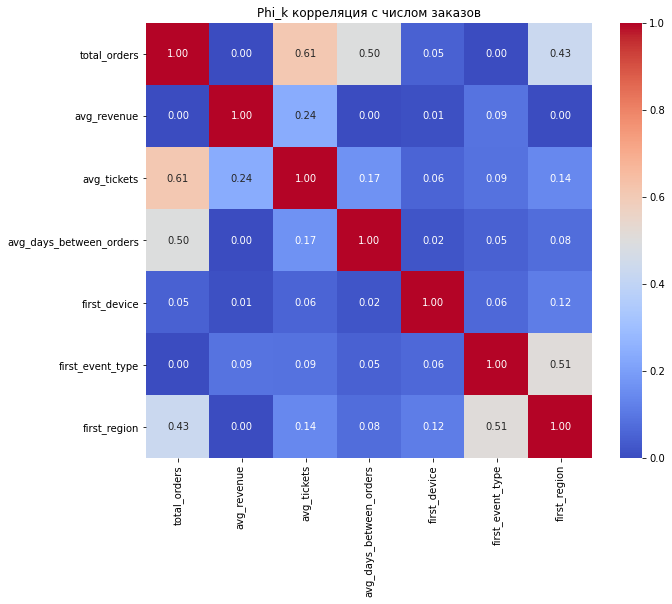

In [55]:
plt.figure(figsize=(10, 8))
sns.heatmap(phi_k_corr, annot=True, fmt='.2f', cmap='coolwarm')
plt.title('Phi_k корреляция с числом заказов')
plt.show()

In [56]:
corr_with_orders = phi_k_corr['total_orders'].sort_values(ascending=False)
corr_with_orders

total_orders               1.000000
avg_tickets                0.613214
avg_days_between_orders    0.497920
first_region               0.431611
first_device               0.048691
avg_revenue                0.000000
first_event_type           0.000000
Name: total_orders, dtype: float64

Признаки, которые сильнее всего связаны с количеством заказов (total_orders), это avg_tickets (0.61), avg_days_between_orders (0.5) и first_region (0.42). Остальные признаки, включая avg_revenue, first_device и first_event_type, почти не коррелируют с числом заказов. Таким образом, большее количество заказов наблюдается у пользователей с разным размером заказа, частотой покупок и региональными особенностями.

### 5. Общий вывод и рекомендации

В конце проекта напишите общий вывод и рекомендации: расскажите заказчику, на что нужно обратить внимание. В выводах кратко укажите:

- **Информацию о данных**, с которыми вы работали, и то, как они были подготовлены: например, расскажите о фильтрации данных, переводе тенге в рубли, фильтрации выбросов.
- **Основные результаты анализа.** Например, укажите:
    - Сколько пользователей в выборке? Как распределены пользователи по числу заказов? Какие ещё статистические показатели вы подсчитали важным во время изучения данных?
    - Какие признаки первого заказа связаны с возвратом пользователей?
    - Как связаны средняя выручка и количество билетов в заказе с вероятностью повторных покупок?
    - Какие временные характеристики влияют на удержание (день недели, интервалы между покупками)?
    - Какие характеристики первого заказа и профиля пользователя могут быть связаны с числом покупок согласно результатам корреляционного анализа?
- Дополните выводы информацией, которая покажется вам важной и интересной. Следите за общим объёмом выводов — они должны быть компактными и ёмкими.

В конце предложите заказчику рекомендации о том, как именно действовать в его ситуации. Например, укажите, на какие сегменты пользователей стоит обратить внимание в первую очередь, а какие нуждаются в дополнительных маркетинговых усилиях.

- **Данные и их качество**

Загружен полный датасет с 290 611 заказами за период июнь–октябрь 2024 года.

Проведена предобработка: пропуски есть только в поле days_since_prev (логично для первой покупки), выручка приведена к рублям, типы данных оптимизированы, выбросы по `revenue_rub` и числу заказов обработаны.

- **Результаты анализа**

Построен профиль 21 933 пользователей с агрегированными характеристиками: средняя выручка, среднее количество билетов, дата первого и последнего заказа, тип устройства и региона первого заказа.

Большинство пользователей делают первую покупку с мобильного устройства (83 %), а первые заказы приходятся на популярные жанры: концерты (44 %) и «другое» (25 %).

Средняя выручка с заказа ≈ 574 руб, медианное количество билетов ≈ 3, среднее время между заказами ≈ 16 дней.

---

62 % пользователей делают повторный заказ, 29 % совершают 5 и более заказов.

«Точки входа», где пользователи чаще возвращаются:

Тип мероприятия: театр (63,8 %), выставки (62,8 %)

Тип устройства: desktop (64,4 %)

Регионы: Шанырский регион (68,3 %), Светополянский округ (65,9 %)

Билетные операторы: Край билетов (65,4 %)

Пользователи с более высокими средними чеками и большим числом билетов немного чаще совершают повторные заказы.

---

Некоторые гипотезы подтвердились, например, пользователи из активных регионов возвращаются чаще. Другие, как влияние спортивных мероприятий на лояльность, не оправдались.

**Рекомендация**

Поддерживать постоянных клиентов и мотивировать новых: Для этого сделать персональные предложения для пользователей компьютеров и любителей театра и выставок. А так же ввести простые бонусы для тех, кто делает повторные заказы, чтобы увеличить их число.

Быть активными в разных регионах: В регионах с высокой лояльностью стоит усилить маркетинг, чтобы удерживать клиентов. В менее активных регионах — стимулировать первые покупки и повторные за счет акций и напоминаний.

Использовать данные для прогнозов: Данные готовы для создания модели, которая будет предсказывать, кто с большой вероятностью вернется за новым заказом. В прогнозировании особенно важны признаки первого заказа (тип мероприятия, устройство, регион) и показатели поведения пользователя (средний чек, количество билетов, частота заказов).


### 6. Финализация проекта и публикация в Git

Когда вы закончите анализировать данные, оформите проект, а затем опубликуйте его.

Выполните следующие действия:

1. Создайте файл `.gitignore`. Добавьте в него все временные и чувствительные файлы, которые не должны попасть в репозиторий.
2. Сформируйте файл `requirements.txt`. Зафиксируйте все библиотеки, которые вы использовали в проекте.
3. Вынести все чувствительные данные (параметры подключения к базе) в `.env`файл.
4. Проверьте, что проект запускается и воспроизводим.
5. Загрузите проект в публичный репозиторий — например, на GitHub. Убедитесь, что все нужные файлы находятся в репозитории, исключая те, что в `.gitignore`. Ссылка на репозиторий понадобится для отправки проекта на проверку. Вставьте её в шаблон проекта в тетрадке Jupyter Notebook перед отправкой проекта на ревью.

**Вставьте ссылку на проект в этой ячейке тетрадки перед отправкой проекта на ревью.**